In [ ]:
import random
import os
import pandas as pd
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from google.colab import drive
import numpy as np

In [ ]:
!pip install transformers

In [ ]:
!pip install transformers

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
drive.mount('/content/drive/')

extracted_labeled_reviews_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/extracted_labeled_reviews.csv',sep = ',')

extracted_labeled_reviews_df.rename(columns={
    'label': 'sentiment',
    'review': 'txt',

}, inplace=True)

extracted_labeled_reviews_df['txt'] = extracted_labeled_reviews_df['txt'].str.replace('\n', ' ').replace('\r', ' ')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# 모델 및 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
#model = AutoModelForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels=2)  # 감성 라벨이 긍정/부정 두개이므로 num_labels=2으로 설정

config = AutoConfig.from_pretrained(
    "monologg/koelectra-base-v3-discriminator",
    num_labels=2,
    hidden_dropout_prob=0.2,  # hidden layer의 dropout 비율을 0.1로 설정
    attention_probs_dropout_prob=0.2  # attention probabilities의 dropout 비율을 0.1로 설정
)

model = AutoModelForSequenceClassification.from_pretrained(
    "monologg/koelectra-base-v3-discriminator",
    config=config
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

        # 토큰화한 길이를 계산하고, max_len보다 큰 데이터를 필터링합니다.
        self.data = data[data['txt'].apply(lambda x: len(self.tokenizer.tokenize(x)) < self.max_len)]

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['txt']
        label = row['sentiment']

        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'ids': inputs['input_ids'].flatten(),
            'mask': inputs['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.data)

In [ ]:
# 데이터를 학습 데이터와 테스트 데이터로 분리한 후, 학습데이터를 다시 검증데이터로 분리
train_data, test_data = train_test_split(extracted_labeled_reviews_df, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.25)

In [ ]:
# DataLoader 준비
train_dataset = ReviewDataset(train_data, tokenizer, max_len=256)
val_dataset = ReviewDataset(val_data, tokenizer, max_len=256)
test_dataset = ReviewDataset(test_data, tokenizer, max_len=256)

Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
train_length = len(train_dataset)
val_length = len(val_dataset)
test_length = len(test_dataset)

print(f"Training Dataset Length: {train_length}")
print(f"Validation Dataset Length: {val_length}")
print(f"Test Dataset Length: {test_length}")

Training Dataset Length: 1583
Validation Dataset Length: 529
Test Dataset Length: 524


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
# 옵티마이저 및 손실함수 설정
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5, weight_decay= 0.0005)
loss_fn = torch.nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수 사용

In [ ]:
# 모델 학습
model.train()
best_accuracy = 0.0
train_loss_list = []  # Added: list to keep track of average loss per epoch
train_accuracy_list = []  # Added: list to keep track of training accuracy per epoch
val_loss_list = []  # Added: list to keep track of validation loss per epoch
val_accuracy_list = []  # Added: list to keep track of validation accuracy per epoch

scheduler = StepLR(optimizer, step_size=10, gamma=0.4)  # Reduce learning rate by a factor of 0.4 every 10 epochs

for epoch in range(13):  # 14 에폭
    model.train()  # 1번 문제점 수정: 에폭 시작 시 모델을 훈련 모드로 설정
    total_loss = 0.0  # Added: variable to keep track of total loss within an epoch
    train_correct = 0  # Added: variable to keep track of correctly predicted samples
    train_total = 0  # Added: variable to keep track of total samples
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['ids']
        attention_mask = batch['mask']
        targets = batch['targets']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
        loss = outputs.loss
        total_loss += loss.item()  # Added: increment total_loss with the batch loss

        # Added: calculate training accuracy for the batch
        _, predicted = torch.max(outputs.logits, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

        loss.backward()
        optimizer.step()

    scheduler.step()  # step the learning rate scheduler

    train_loss_list.append(total_loss/len(train_loader))  # Added: compute average loss and append to list

    # Added: compute training accuracy for the epoch and append to list
    train_accuracy = train_correct / train_total
    train_accuracy_list.append(train_accuracy)

    model.eval()
    val_loss = 0.0  # Added: variable to keep track of total validation loss
    preds = []
    actual = []
    for batch in val_loader:
        input_ids = batch['ids']
        attention_mask = batch['mask']
        targets = batch['targets']
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask,labels=targets)
            val_loss += outputs.loss.item()  # Added: increment val_loss with the batch loss
        preds.extend(torch.argmax(outputs.logits, axis=-1).tolist())
        actual.extend(targets.tolist())

    # Added: compute average validation loss and append to list
    val_loss_list.append(val_loss/len(val_loader))

    # 정확도 계산
    accuracy = accuracy_score(actual, preds)
    val_accuracy_list.append(accuracy)
    print(f"Epoch {epoch+1} - Validation Accuracy: {accuracy} - Train Accuracy: {train_accuracy}")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss/len(val_loader)} - Train Loss: {total_loss/len(train_loader)}")

    # 가장 좋은 성능을 보인 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/L25_drop02_10epoch_sche0_4_best_model.pth')

Epoch 1 - Validation Accuracy: 0.6011342155009451 - Train Accuracy: 0.4933670246367656
Epoch 1 - Val Loss: 0.6902727087338766 - Train Loss: 0.6941788026264736
Epoch 2 - Validation Accuracy: 0.6257088846880907 - Train Accuracy: 0.5394819962097284
Epoch 2 - Val Loss: 0.6894557277361552 - Train Loss: 0.6896628226552691
Epoch 3 - Validation Accuracy: 0.720226843100189 - Train Accuracy: 0.5868603916614024
Epoch 3 - Val Loss: 0.6844893495241801 - Train Loss: 0.6851647070475987
Epoch 4 - Validation Accuracy: 0.7410207939508506 - Train Accuracy: 0.607706885660139
Epoch 4 - Val Loss: 0.6783228516578674 - Train Loss: 0.682396011693137
Epoch 5 - Validation Accuracy: 0.7958412098298677 - Train Accuracy: 0.6519267214150347
Epoch 5 - Val Loss: 0.6694900592168173 - Train Loss: 0.6756606783185687
Epoch 6 - Validation Accuracy: 0.833648393194707 - Train Accuracy: 0.7087807959570436
Epoch 6 - Val Loss: 0.6487642526626587 - Train Loss: 0.663455171244485
Epoch 7 - Validation Accuracy: 0.8638941398865785 -

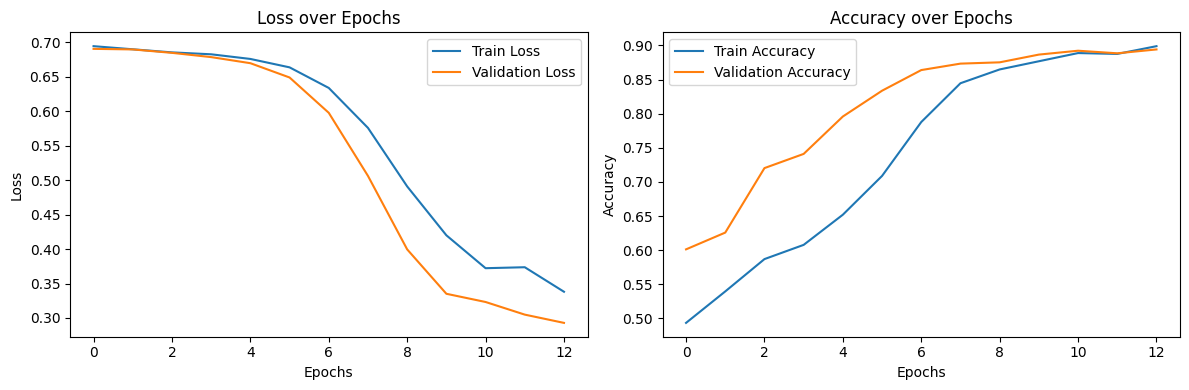

In [ ]:
# 손실 그래프 그리기
plt.figure(figsize=(12, 4))

# 훈련 및 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 훈련 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label="Train Accuracy")
plt.plot(val_accuracy_list, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/L25_drop02_10epoch_sche0_4_best_model.pth'))
model.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()

    eval_total_loss = 0.0
    eval_correct_preds = 0
    eval_total_preds = 0
    criterion = torch.nn.CrossEntropyLoss()
    eval_preds = []
    eval_actual = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['ids']
            attention_mask = batch['mask']
            labels = batch['targets']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            # Calculate loss
            loss = criterion(outputs.logits, labels)
            eval_total_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            eval_total_preds += labels.size(0)
            eval_correct_preds += (predicted == labels).sum().item()

            eval_preds.extend(predicted.tolist())
            eval_actual.extend(targets.tolist())

    eval_accuracy = eval_correct_preds / eval_total_preds  # Updated variable name
    avg_loss = eval_total_loss / len(test_loader)

    return eval_accuracy, avg_loss, eval_preds, eval_actual

eval_accuracy, avg_loss, _, _ = evaluate_model(model, test_loader)
print(f"Evaluation Accuracy: {eval_accuracy * 100:.2f}%")
print(f"Evaluation Average Loss: {avg_loss:.4f}")


Evaluation Accuracy: 89.89%
Evaluation Average Loss: 0.3105
